In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

# add parent directory to sys.path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from lib.functions import *

In [3]:
df = pd.read_csv("../data/diabetes_prediction_dataset.csv")

### Data Cleaning

In [4]:
# drop rows
df=df.loc[df['smoking_history'] != 'No Info']
df=df.loc[df['gender'] != 'Other']

# aggregate values
df['smoking_history'].loc[df["smoking_history"] == 'not current'] = 'former'

<Axes: xlabel='smoking_history', ylabel='count'>

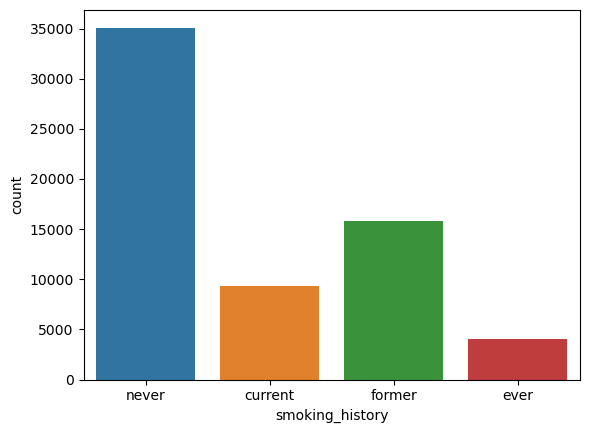

In [5]:
sns.countplot(df, x='smoking_history')

<Axes: xlabel='HbA1c_level', ylabel='count'>

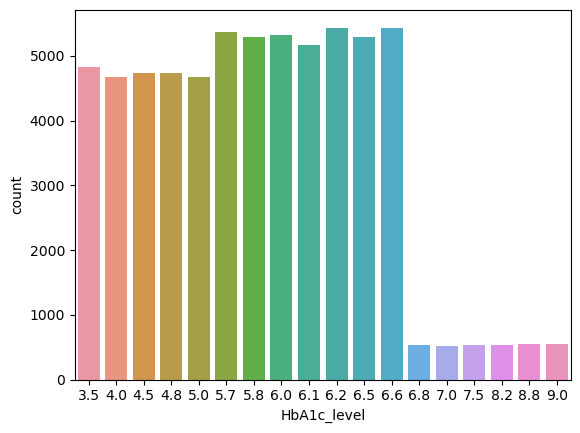

In [6]:
sns.countplot(df, x='HbA1c_level')

<Axes: xlabel='bmi', ylabel='Count'>

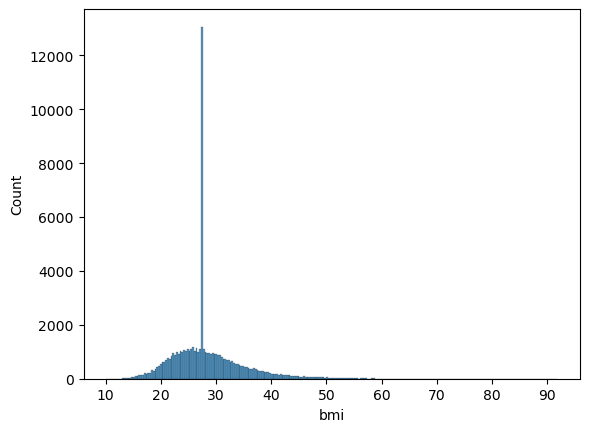

In [7]:
sns.histplot(df, x='bmi')

In [8]:
df.loc[df['bmi'] == 27.32].shape

(12045, 9)

In [9]:
df = df.loc[df['bmi'] != 27.32]

In [10]:
df['bmi'].describe()

count    52127.000000
mean        28.679424
std          7.205693
min         10.080000
25%         23.650000
50%         27.620000
75%         32.480000
max         91.820000
Name: bmi, dtype: float64

<Axes: xlabel='blood_glucose_level', ylabel='count'>

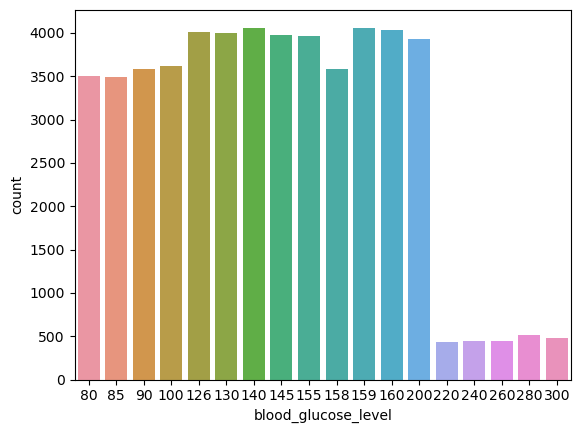

In [11]:
sns.countplot(df, x='blood_glucose_level')

<Axes: xlabel='age', ylabel='Count'>

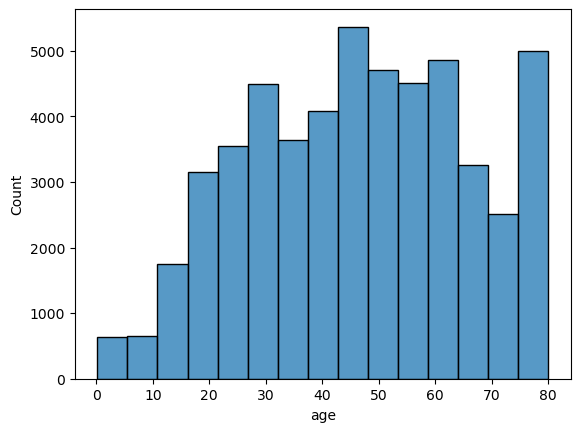

In [12]:
sns.histplot(df, x='age', bins=15)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52127 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               52127 non-null  object 
 1   age                  52127 non-null  float64
 2   hypertension         52127 non-null  int64  
 3   heart_disease        52127 non-null  int64  
 4   smoking_history      52127 non-null  object 
 5   bmi                  52127 non-null  float64
 6   HbA1c_level          52127 non-null  float64
 7   blood_glucose_level  52127 non-null  int64  
 8   diabetes             52127 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 4.0+ MB


### Feature Engineering

In [14]:
# transform categorical columns to numerical
df["smoking_history"] = df["smoking_history"].map({'never': 0, 'former': 1, 'current': 2, 'ever': 3})
df["gender"] = df["gender"].map({'Male': 0, 'Female': 1})
df = df.rename(columns={'gender': 'gender_female'})

In [15]:
df.head(3)

,gender_female,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,80.0,0,1,0,25.19,6.6,140,0
3,1,36.0,0,0,2,23.45,5.0,155,0
4,0,76.0,1,1,2,20.14,4.8,155,0


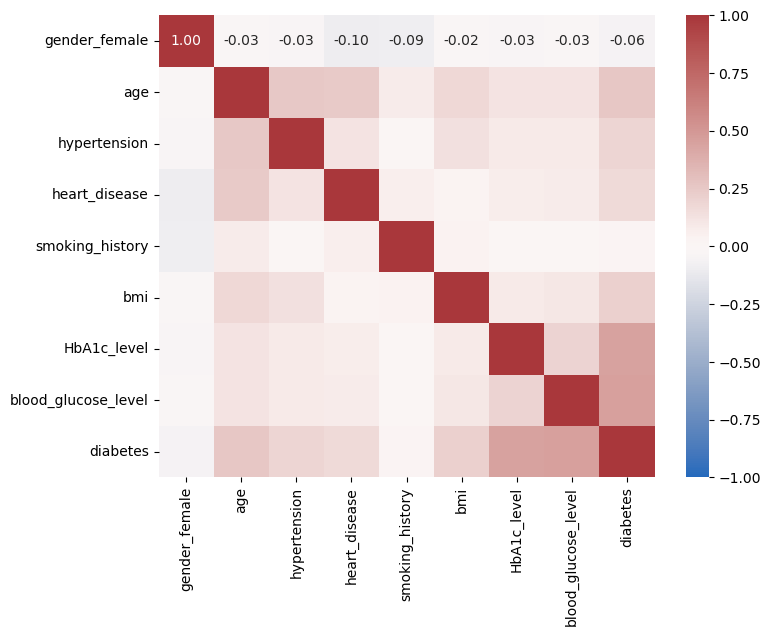

In [42]:
df_corr = df.corr()
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_corr, annot=True, vmin = -1, vmax = 1, fmt=".2f", cmap='vlag')
plt.show()

In [17]:
# define features and target
features = df.drop(columns = ["diabetes"])
target = df["diabetes"]

In [18]:
# split data into training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)

In [19]:
# normalize features

from sklearn.preprocessing import MinMaxScaler, StandardScaler
#normalizer = MinMaxScaler()
normalizer = StandardScaler()

X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

pd.DataFrame(X_train_norm).head(3)

,0,1,2,3,4,5,6,7
0,0.795912,0.072461,-0.343277,-0.228601,-0.761488,-0.348444,0.203419,-1.289744
1,0.795912,-0.438687,-0.343277,-0.228601,-0.761488,-0.366506,0.203419,-1.172409
2,0.795912,-0.592031,-0.343277,-0.228601,-0.761488,-0.062230,0.931687,1.408965


### Model Training and Evaluation

In [183]:
# total share of positives in the dataset
df['diabetes'].value_counts()[1] / (df['diabetes'].value_counts()[0] + df['diabetes'].value_counts()[1])
# tp / (tp + fp)

0.1160626930381568

In [191]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score

# Define models
models_dict = {
  'Random Forest n=100 depth=10': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
  'Adaptive Boosting Logistic Reg. n=100': AdaBoostClassifier(LogisticRegression(), n_estimators=100),
  'Gradient Boosting n=100 depth=10': GradientBoostingClassifier(max_depth=10, n_estimators=100),
  'KNN': KNeighborsClassifier(),
  'Logistic Regression': LogisticRegression(),
}

# Train and evaluate models
models = []
accuracies = []
sensitivities = []
specificities = []

for name, model in models_dict.items():
  # Train the model
  model.fit(X_train_norm, y_train)
  
  # Make predictions
  y_pred = model.predict(X_test_norm)
  
  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred)

  # Calculate sensitivity [tp / (tp + fn)] (= recall)
  sensitivity = recall_score(y_test, y_pred)

  # Calculate specificity  [tn / (tn + fp)]
  specificity = recall_score(y_test, y_pred, pos_label=0)

  models.append(name)
  accuracies.append(accuracy)
  sensitivities.append(sensitivity)
  specificities.append(specificity)

df_results = pd.DataFrame({'model': models,
                           'accuracy': accuracies,
                           'sensitivity': sensitivities,
                           'specificity': specificities})

In [192]:
df_results.sort_values(by='sensitivity', ascending=False)

,model,accuracy,sensitivity,specificity
9,Gradient Boosting n=100 depth=50,0.939382,0.732370,0.965726
10,Gradient Boosting n=200 depth=50,0.939574,0.731521,0.966050
12,Gradient Boosting n=200 depth=100,0.940054,0.731521,0.966591
11,Gradient Boosting n=100 depth=100,0.938903,0.728972,0.965618
8,Gradient Boosting n=100 depth=20,0.957031,0.712829,0.988107
7,Gradient Boosting n=100 depth=10,0.959620,0.701784,0.992432
4,Random Forest n=500 depth=50,0.961443,0.692438,0.995675
1,Random Forest n=100 depth=20,0.962402,0.691589,0.996865
3,Random Forest n=200 depth=50,0.961538,0.690739,0.996000
2,Random Forest n=100 depth=50,0.961155,0.689890,0.995675


To-dos:
* Cross Validation
* Correlation test
* dummies for 'smoking history'
* PCA
* Outliers
* other KPIs? (MSE, ...)

In [75]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score

# define model types
model_types_dict = {'RandomForestClassifier': RandomForestClassifier,
                    'GradientBoostingClassifier': GradientBoostingClassifier}

# define the parameter grid
n_estimators_grid = [100]
max_depth_grid = [5, 10]

model_types_list = []
n_estimators_list = []
max_depth_list = []
accuracies = []
sensitivities = []
specificities = []

#loop over models
for model_type_name, model_type in model_types_dict.items():
    print(f'Model type: {model_type_name}')
    # loop over parameter grid
    for n_estimators in n_estimators_grid:
        print(f'n_estimators: {n_estimators}')
        for max_depth in max_depth_grid:
            print(f'max_depth: {max_depth}')
            # Create model
            model = model_type(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

            # Train the model
            model.fit(X_train_norm, y_train)

            # Make predictions
            y_pred = model.predict(X_test_norm)

            # Calculate accuracy
            accuracy = accuracy_score(y_test, y_pred)

            # Calculate sensitivity [tp / (tp + fn)] (= recall)
            sensitivity = recall_score(y_test, y_pred)

            # Calculate specificity  [tn / (tn + fp)]
            specificity = recall_score(y_test, y_pred, pos_label=0)

            model_types_list.append(model_type_name)
            n_estimators_list.append(n_estimators)
            max_depth_list.append(max_depth)
            accuracies.append(accuracy)
            sensitivities.append(sensitivity)
            specificities.append(specificity)

df_grid_search = pd.DataFrame({'model_type': model_types_list,
                               'n_estimators': n_estimators_list,
                               'max_depth': max_depth_list,
                               'accuracy': accuracies,
                               'sensitivity': sensitivities,
                               'specificity': specificities})

Model type: RandomForestClassifier
n_estimators: 100
max_depth: 5
max_depth: 10
Model type: GradientBoostingClassifier
n_estimators: 100
max_depth: 5
max_depth: 10


<Axes: xlabel='max_depth', ylabel='sensitivity'>

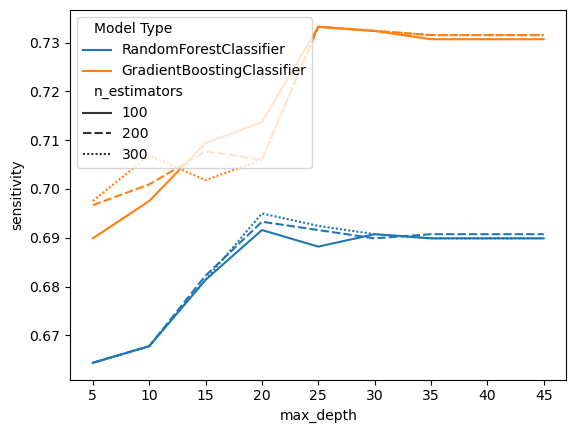

In [74]:
sns.lineplot(df_grid_search, x='max_depth', y='sensitivity', hue='Model Type', style='n_estimators')